# WeatherPy

### Author:  Jose Tomines
### Date:  2018-12-09

### Analysis
* As expected, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). More interestingly, however, is the fact that the southern hemisphere tends to be warmer this time of year than the northern hemisphere. This is due to the tilt of the earth that is the determiner of seasons experienced by the earth.
* Highest temperatures are seen between -30 Deg. to -10 Deg. Latitude, reaching above 35 Deg. Celsius.
* Temperatures drop below 0 Deg. Celsius north of 30 Deg. Latitude, with the lowest temperatures (below -40 Deg. Celsius) occuring near 70 Deg. Latitude.
* There is no strong relationship between latitude & humidity.  Majority of cities are within the 70-100% humidity range, with a large band of cities at the 100% humidity level on this date.  Is this because people prefer NOT to build cities in very dry locations?
* There is no strong relationship between latitude and cloudiness. However, it is interesting to see that a strong band of cities sits at 0%, 75%, and at 90% cloudiness.  Is this due to the tendancy to round % cloudiness to the nearest 5%?
* There is no strong relationship between latitude and wind speed. However, in northern hemispheres there is a fewcities above 12 m/sec around 48 Deg. Latitude.
* See additional trends discussed in the Bonus Plots subsection below:

### Notes
* In this version, I followed the steps as outlined in the Starter Code, where you generate a large number (Greater than 500) of geographic coordinates, use CitiPy to find the nearest city, and then use the Weather API to get the weather information if the city exists in the Weather API.  Unfortunately, it bothered me that I first had to generate a larger number of coordinates by arbitrarily declaring a larger number (in this case 1000) of coordinates and their nearest cities, and then hope that I can get more than 500 cities and their weather data of this original list from the Weather API.  There still was a possibility that even with 1000 coordinates and the corresponding nearest cities, I may get less than 500 weather data points after requesting the 1000 cities from the API... and thus... have to re-run it again!  SO!!!!!!
* I created an ALTERNATE version of this python script that allowed me to get exactly 500 valid cities from the Weather API by including the generation of geographic coordinates, the determination of the nearest city using CitiPy, and then calling the Weather API to get the weather data, all in the same While Loop until exactly 500 cities were found.  The ALTERNATE version of this Python script is called:  JTomines_WeatherPy_Alt.  All csv and png outputs produced by that alternate file will have _Alt appended to the filename.
* Even though each city was determined by randomly geographic coordinates, the coordinates actually used in the graphs were those stored for that city in the Weather API.  The reason is that even though the CitiPy determined the closest city to those random coordinates, the city may in actuality be many degrees off in latitude from the generated coordinates...  especially if the coordinates point to the middle of an ocean
* API requests specifically asked for metric measurements
* To avoid violating the 60 requests per minute rule in using the Weather API, I've added a 1 second delay after each API request.
* This script also stores the processing log with the datestamp within the filename.

### Bonus Plots
The Weather API provides data on sunrise time and sunset time.  Because of this, I decided to add some additionals plots to view how latitude influences the sunrise and sunset times of the cities. The following winter seasonal trends were observed very clearly:
* As the northern latitude increases, the Sunrise time occurs more later in the day
* As the northern latitude increases, the Sunset time occurs more earlier in the day
* Correspondingly, the overall duration of sunlight decreases the further north you go
* The maximum duration of daylight is calculated to be above 17 hours for locations near -35 Deg. Latitude
* The curve distinctly shows that daylight hours drop dramatically from 3 hours to 1 hour around 77 Deg Latitude
This is the nature of the earth's tilt and it's effect to sunlight received, and hence colder temperatures during the winter season.

The final plot shows the geographic coordinates of all the cities used.  You can clearly see the edges of all the continents.  This is because of the fact that oceans cover 70% of the earth surface, and since we are randomly generating coordinates for the entire globe, and then finding the nearest city to those coordinates, we end up with predominantly more coastal cities.  When plotted, this allows the continental edges to be more distinct..

In [26]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time as tm
from datetime import date
from datetime import time
from datetime import datetime as dt
from pprint import pprint

# Declare API key
api_key = "1c9e087c0c96b654d94b3f5c8b571e81"

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# Output File (CSV)
output_data_file = "output/city_weather.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding cities, countries, and geographic coordinates
cities = []
countries = []
genLatitude = []
genLongitude = []

# Get a list of 500 cities
while len(cities) < 1000:
    
    # Generate random set of geographic coordinates
    degLat = np.random.uniform(low=-90.000, high=90.000)
    degLong = np.random.uniform(low=-180.000, high=180.000)

    # Use citipy to get nearest city to geographic coordinates
    nearestcity = citipy.nearest_city(degLat, degLong)
    
    # Store the city if it isn't already in the list
    if nearestcity.city_name not in cities:
        cities.append(nearestcity.city_name)
        countries.append(nearestcity.country_code)
        genLatitude.append(degLat)
        genLongitude.append(degLong)
    
# Print the city count to confirm sufficient count
len(cities)

1000

In [3]:
# Create dataframe for city
cities_df = pd.DataFrame({"City": cities,
                          "Country": countries,
                          "Generated_Latitude":  genLatitude,
                          "Generated_Longitude":  genLongitude})
cities_df.head()

,City,Country,Generated_Latitude,Generated_Longitude
0,araguaina,br,-7.074655,-48.713698
1,barentsburg,sj,88.845682,-4.706980
2,manyoni,tz,-5.721279,34.800201
3,kodiak,us,49.669194,-154.614920
4,nikolskoye,ru,46.378701,172.362736


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [5]:
# Initialize variables to capture the weather API data.
itemNum = 1
orig_city = []     # Note that I also kept the original city and country code that was retrieved by citipy
orig_country = []  #   I guess it is my fear of missing data
dte = []
cty = []
con = []
lon = []
lat = []
tmp = []
hum = []
cld = []
wnd = []
sunrise = []
sunset = []
processing_log=[]  # To store processing log being displayed.  This will also be saved to file so as not to lose the information
pullDate = str(date.today())

# Start logging to output
logText = "Beginning Data Retrieval on " + pullDate
print(logText)
processing_log.append(logText)
logText = "--------------------------------------"
print(logText)
processing_log.append(logText)

# Create loop to request weather data for each city
for x in range(len(cities_df)):
    query_url = "http://api.openweathermap.org/data/2.5/weather?q="+cities_df.iloc[x, 0]+","+cities_df.iloc[x, 1]+"&units=metric&APPID="+api_key
    weather_response = requests.get(query_url)
    weather_json = weather_response.json()    

    if 'weather' not in weather_json:
        logText = "City not found | " + cities_df.iloc[x, 0] + ", " + cities_df.iloc[x, 1] + " | Skipping..."
        print(logText)
        processing_log.append(logText)
    else:
        logText = "Processing Record " + str(itemNum) + " | " + cities_df.iloc[x, 0] + ", " + cities_df.iloc[x, 1]
        print(logText)
        processing_log.append(logText)

        # Get all the data for new DataFrame
        orig_city.append(cities_df.iloc[x, 0])
        orig_country.append(cities_df.iloc[x, 1])
        dte.append(weather_json['dt'])
        cty.append(weather_json['name'])
        con.append(weather_json['sys']['country'])
        lon.append(weather_json['coord']['lon'])
        lat.append(weather_json['coord']['lat'])
        tmp.append(weather_json['main']['temp_max'])
        hum.append(weather_json['main']['humidity'])
        cld.append(weather_json['clouds']['all'])
        wnd.append(weather_json['wind']['speed'])
        sunrise.append(weather_json['sys']['sunrise'])
        sunset.append(weather_json['sys']['sunset'])
        
        itemNum += 1  #Increment itemNumber by 1
        
    tm.sleep(1) #This delay is to make sure we don't go over the 60 request per 60 second API limit

Beginning Data Retrieval on 2018-12-09
--------------------------------------
Processing Record 1 | araguaina, br
City not found | barentsburg, sj | Skipping...
Processing Record 2 | manyoni, tz
Processing Record 3 | kodiak, us
Processing Record 4 | nikolskoye, ru
Processing Record 5 | arenys de mar, es
City not found | aflu, dz | Skipping...
Processing Record 6 | khandbari, np
City not found | mataura, pf | Skipping...
Processing Record 7 | puerto ayora, ec
Processing Record 8 | mingoyo, tz
Processing Record 9 | puerto santander, co
Processing Record 10 | meulaboh, id
Processing Record 11 | grindavik, is
Processing Record 12 | ushuaia, ar
Processing Record 13 | avarua, ck
Processing Record 14 | saint-philippe, re
Processing Record 15 | ponta do sol, cv
Processing Record 16 | yunhe, cn
Processing Record 17 | busselton, au
Processing Record 18 | zhuhai, cn
Processing Record 19 | alice springs, au
Processing Record 20 | ambala, in
Processing Record 21 | new norfolk, au
Processing Record 

City not found | pousat, kh | Skipping...
Processing Record 184 | fairbanks, us
City not found | mys shmidta, ru | Skipping...
Processing Record 185 | curup, id
Processing Record 186 | pacific grove, us
Processing Record 187 | marsa matruh, eg
City not found | shchelyayur, ru | Skipping...
Processing Record 188 | atar, mr
Processing Record 189 | gijon, es
Processing Record 190 | bar harbor, us
Processing Record 191 | beringovskiy, ru
Processing Record 192 | hambantota, lk
Processing Record 193 | hashimoto, jp
Processing Record 194 | yulara, au
Processing Record 195 | mugur-aksy, ru
City not found | san quintin, mx | Skipping...
Processing Record 196 | yellowknife, ca
Processing Record 197 | kiama, au
Processing Record 198 | sosnogorsk, ru
Processing Record 199 | sorong, id
Processing Record 200 | uray, ru
Processing Record 201 | north bend, us
City not found | grand river south east, mu | Skipping...
Processing Record 202 | gopalganj, in
Processing Record 203 | aviles, es
Processing Re

Processing Record 375 | cayenne, gf
Processing Record 376 | hamilton, bm
City not found | termiz, uz | Skipping...
Processing Record 377 | sao joao da barra, br
Processing Record 378 | ribeira grande, pt
Processing Record 379 | apricena, it
Processing Record 380 | lavrentiya, ru
Processing Record 381 | morar, in
Processing Record 382 | turochak, ru
City not found | paradwip, in | Skipping...
Processing Record 383 | samdrup jongkhar, bt
City not found | tonj, sd | Skipping...
City not found | barbar, sd | Skipping...
City not found | asfi, ma | Skipping...
Processing Record 384 | montrose, us
Processing Record 385 | mezhdurechensk, ru
City not found | malwan, in | Skipping...
Processing Record 386 | maseru, ls
Processing Record 387 | sao pedro do sul, br
Processing Record 388 | jalu, ly
Processing Record 389 | tomatlan, mx
Processing Record 390 | acari, pe
Processing Record 391 | kichera, ru
Processing Record 392 | varniai, lt
Processing Record 393 | marsh harbour, bs
Processing Record 

Processing Record 565 | knysna, za
Processing Record 566 | south lake tahoe, us
Processing Record 567 | westerland, de
Processing Record 568 | caravelas, br
Processing Record 569 | kloulklubed, pw
Processing Record 570 | aklavik, ca
Processing Record 571 | broken hill, au
Processing Record 572 | dongsheng, cn
Processing Record 573 | kodyma, ua
Processing Record 574 | weyburn, ca
Processing Record 575 | shimanovsk, ru
Processing Record 576 | huilong, cn
City not found | ngukurr, au | Skipping...
City not found | katha, mm | Skipping...
Processing Record 577 | wawa, ca
Processing Record 578 | champerico, gt
Processing Record 579 | vytegra, ru
Processing Record 580 | santo amaro da imperatriz, br
Processing Record 581 | debre tabor, et
City not found | bairiki, ki | Skipping...
Processing Record 582 | kieta, pg
City not found | tumannyy, ru | Skipping...
Processing Record 583 | smithers, ca
Processing Record 584 | zhob, pk
Processing Record 585 | katobu, id
Processing Record 586 | naustda

Processing Record 760 | aanekoski, fi
Processing Record 761 | imbituba, br
Processing Record 762 | loukhi, ru
Processing Record 763 | port macquarie, au
Processing Record 764 | vilcun, cl
Processing Record 765 | qianguo, cn
Processing Record 766 | quatre cocos, mu
Processing Record 767 | wuwei, cn
City not found | mahon, es | Skipping...
Processing Record 768 | kamina, cd
Processing Record 769 | viedma, ar
Processing Record 770 | antalaha, mg
Processing Record 771 | karlstad, se
Processing Record 772 | whyalla, au
Processing Record 773 | havre, us
Processing Record 774 | bollnas, se
Processing Record 775 | leh, in
Processing Record 776 | kashan, ir
Processing Record 777 | inza, ru
Processing Record 778 | diego de almagro, cl
Processing Record 779 | poltavka, ru
Processing Record 780 | saint-louis, sn
City not found | utiroa, ki | Skipping...
Processing Record 781 | dicabisagan, ph
Processing Record 782 | kutum, sd
Processing Record 783 | vagur, fo
Processing Record 784 | nagorsk, ru
Pr

In [6]:
# Verify number of records
len(orig_city)  

887

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [7]:
# Create DataFrame for weather information
city_weather_df = pd.DataFrame({"Original City" : orig_city,
                                "Original Country" : orig_country,
                                "Date" : dte,
                                "API City" : cty,
                                "API Country" : con,
                                "API Longitude" : lon,
                                "API Latitude" : lat,
                                "Max Temperature" : tmp,
                                "% Humidity" : hum,
                                "% Cloudiness" : cld,
                                "Wind Speed" : wnd,
                                "Sunrise Time" : sunrise,
                                "Sunset Time" : sunset
                               })

log_df = pd.DataFrame({"Processing Log Item" : processing_log})

city_weather_df.head()

,Original City,Original Country,Date,API City,API Country,API Longitude,API Latitude,Max Temperature,% Humidity,% Cloudiness,Wind Speed,Sunrise Time,Sunset Time
0,araguaina,br,1544411873,Araguaina,BR,-48.21,-7.19,22.55,97,76,1.76,1544431784,1544476906
1,manyoni,tz,1544411875,Manyoni,TZ,34.84,-5.75,17.65,92,88,1.51,1544411995,1544456818
2,kodiak,us,1544410500,Kodiak,US,-94.76,39.95,-2.90,95,1,1.31,1544448597,1544482434
3,nikolskoye,ru,1544409000,Nikolskoye,RU,30.79,59.70,-2.00,92,20,5.00,1544424289,1544446452
4,arenys de mar,es,1544409000,Arenys de Mar,ES,2.55,41.58,11.00,93,0,3.31,1544425529,1544458778


In [8]:
log_df.head()

,Processing Log Item
0,Beginning Data Retrieval on 2018-12-09
1,--------------------------------------
2,"Processing Record 1 | araguaina, br"
3,"City not found | barentsburg, sj | Skipping..."
4,"Processing Record 2 | manyoni, tz"


In [9]:
# Save to file
city_weather_df.to_csv(output_data_file, index=False, encoding='utf-8')
log_file = "output/processing_log_" +  pullDate
log_df.to_csv(log_file, index=False, encoding='utf-8')

### Retrieve Data Frame from File
#### To be used only if code in previous cells were executed in a previous session.

In [ ]:
# Note:  This cell is used to load the previous dataframe.  Because the API call cell would take a long time, if we had already
#        shut down the kernell for the day, and restarted to work on this script, running the entire file
#        to get to this point would be impractical.  Instead we are loading previous dataframe to continue working on developing
#        this solution.
#        DO NOT RUN THIS CELL if you did run all of the previous cells in this kernell session.

# Load file to dataframe
# Load to dataframe
city_weather_df = pd.read_csv("output/city_weather.csv")

city_weather_df.head()

### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

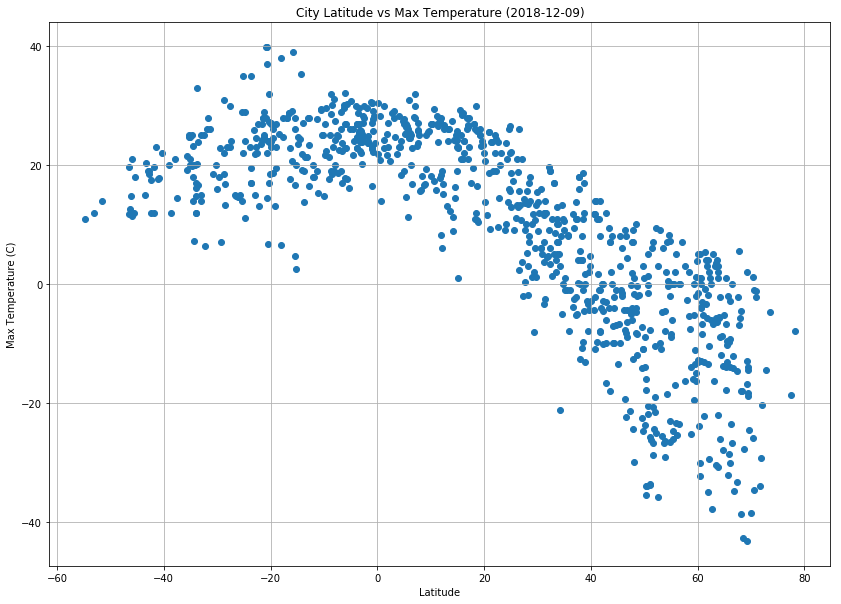

In [16]:
# Plot Latitude vs. Temperature
x = city_weather_df["API Latitude"]
y = city_weather_df["Max Temperature"]

title = "City Latitude vs Max Temperature (" + pullDate +")"
plt.scatter(x, y)
plt.title(title)
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (C)")

plt.grid()

plt.gcf().set_size_inches(14, 10)

# Save the Figure
plt.savefig("output/LatitudeVsMaxTemperature.png")

# Show the Figure
plt.show()

#### Latitude vs. Humidity Plot

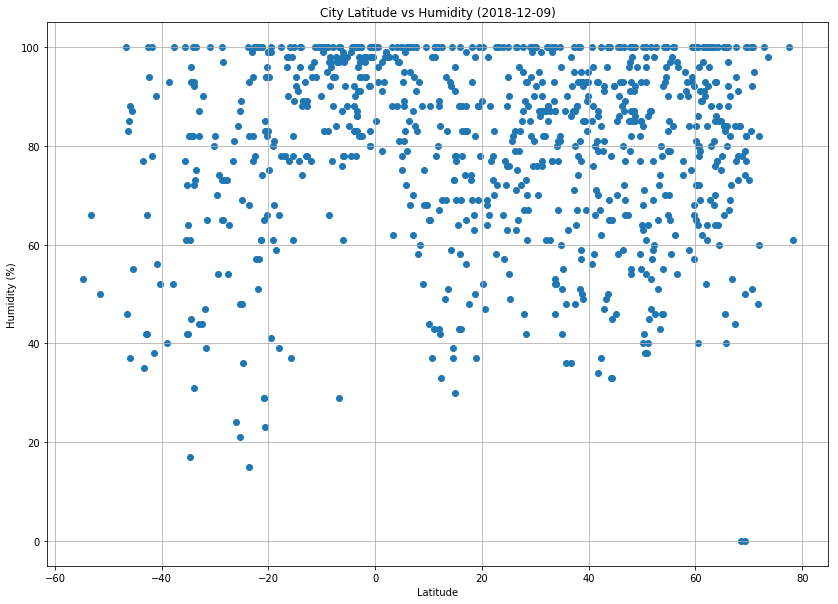

In [18]:
# Plot Latitude vs Humidity
x = city_weather_df["API Latitude"]
y = city_weather_df["% Humidity"]

title = "City Latitude vs Humidity (" + pullDate +")"
plt.scatter(x, y)
plt.title(title)
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

plt.ylim(-5, 105)

plt.grid()

plt.gcf().set_size_inches(14, 10)

# Save the Figure
plt.savefig("output/LatitudeVsHumidity.png")

# Show the Figure
plt.show()

#### Latitude vs. Cloudiness Plot

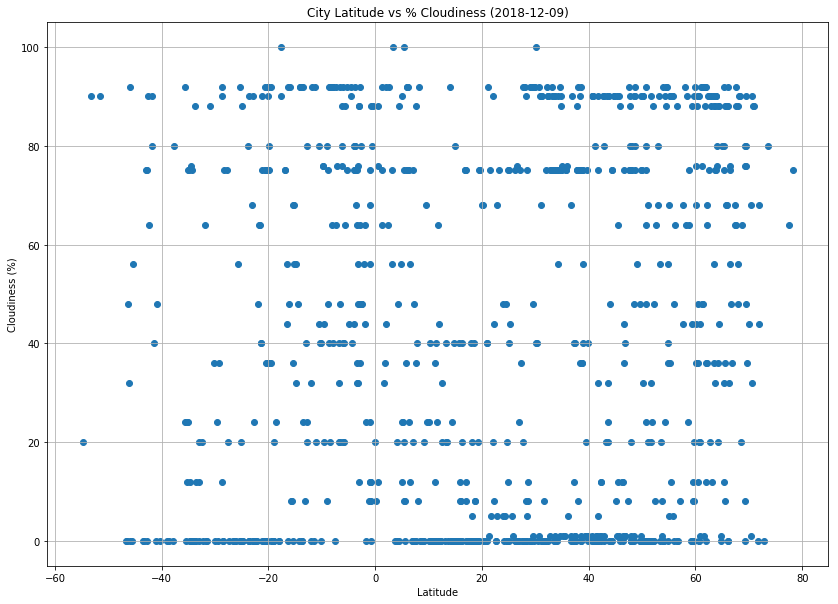

In [19]:
# Plot Latitude vs Cloudiness
x = city_weather_df["API Latitude"]
y = city_weather_df["% Cloudiness"]

title = "City Latitude vs % Cloudiness (" + pullDate +")"
plt.scatter(x, y)
plt.title(title)
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

plt.grid()

plt.gcf().set_size_inches(14, 10)

# Save the Figure
plt.savefig("output/LatitudeVsCloudiness.png")

# Show the Figure
plt.show()

#### Latitude vs. Wind Speed Plot

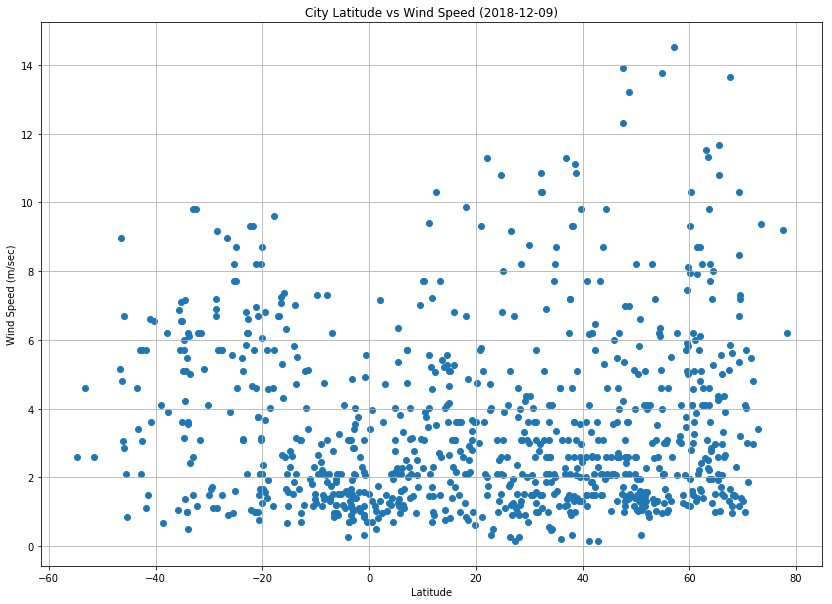

In [20]:
# Plot Latitude vs Wind Speed
x = city_weather_df["API Latitude"]
y = city_weather_df["Wind Speed"]

title = "City Latitude vs Wind Speed (" + pullDate +")"
plt.scatter(x, y)
plt.title(title)
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (m/sec)")

plt.grid()

plt.gcf().set_size_inches(14, 10)

# Save the Figure
plt.savefig("output/LatitudeVsWindSpeed.png")

# Show the Figure
plt.show()

### Bonus Plots
Decided to add these plots because they are very interesting to visualize known phenomenon regarding daylight and latitude, and the randomization of geo coordinates.

#### Timezone Adjustment
Because the sunrise and sunset times from Weather API are provided in UTC time (based on the time in GMT timezone), the local time of the sunrise and sunset must be calculated by determining the timezone of the city from the longitudinal coordinate, and adjusting the times accordingly.

In [22]:
# Determine timezone adjustment

# Note:  The assumption is that the prime meridian (0 degrees ) is exactly in the middle of GMT time zone.  
#        Since each timezone is 15 degrees in width, therefore, the prime meridian goes from -7.5 degrees to 7.5 degrees.
#        All other timezones are then calculated by adding or subtracting 15 degrees from the GMT longitudinal boundary.
#        In actuality, time zones do not strictly follow longitudinal borders, (hence outliers seen in the graph)
#        but this also provides more ideal plotting.

# Provide the longitudinal edges of the timezones
bins = [-180, -172.5, -157.5, -142.5, -127.5, -112.5, -97.5, -82.5, -67.5, -52.5, -37.5, -22.5, -7.5, 7.5, 22.5, 37.5, 52.5,
        67.5, 82.5, 97.5, 112.5, 127.5, 142.5, 157.5, 172.5, 180]

# Provide the hour adjustment for the timezone bounded by the bin edges
hourAdjust = [-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Cut to determine the hour adjustment for each city
city_weather_df["Timezone"] = pd.cut(city_weather_df["API Longitude"], bins, labels = hourAdjust)
city_weather_df["Timezone"] = pd.to_numeric(city_weather_df["Timezone"])

# Adjust the Sunrise and Sunset times to be local times, and the convert so it is the number of seconds elapsed since midnight
#    and create new columns
city_weather_df["Adjusted Sunrise"] = (city_weather_df["Sunrise Time"] + (city_weather_df["Timezone"] *60*60)) % (24*60*60)
city_weather_df["Adjusted Sunset"] = (city_weather_df["Sunset Time"] + (city_weather_df["Timezone"] *60*60)) % (24*60*60)

# Determine duration of daylight in seconds that each city will experience for the day as a new column
city_weather_df["Daylight Time"] = city_weather_df["Adjusted Sunset"] - city_weather_df["Adjusted Sunrise"]

city_weather_df.head()

,Original City,Original Country,Date,API City,API Country,API Longitude,API Latitude,Max Temperature,% Humidity,% Cloudiness,Wind Speed,Sunrise Time,Sunset Time,Timezone,Adjusted Sunrise,Adjusted Sunset,Daylight Time
0,araguaina,br,1544411873,Araguaina,BR,-48.21,-7.19,22.55,97,76,1.76,1544431784,1544476906,-3,20984,66106,45122
1,manyoni,tz,1544411875,Manyoni,TZ,34.84,-5.75,17.65,92,88,1.51,1544411995,1544456818,2,19195,64018,44823
2,kodiak,us,1544410500,Kodiak,US,-94.76,39.95,-2.90,95,1,1.31,1544448597,1544482434,-6,26997,60834,33837
3,nikolskoye,ru,1544409000,Nikolskoye,RU,30.79,59.70,-2.00,92,20,5.00,1544424289,1544446452,2,31489,53652,22163
4,arenys de mar,es,1544409000,Arenys de Mar,ES,2.55,41.58,11.00,93,0,3.31,1544425529,1544458778,0,25529,58778,33249


#### Latitude vs Duration of Daylight Plot

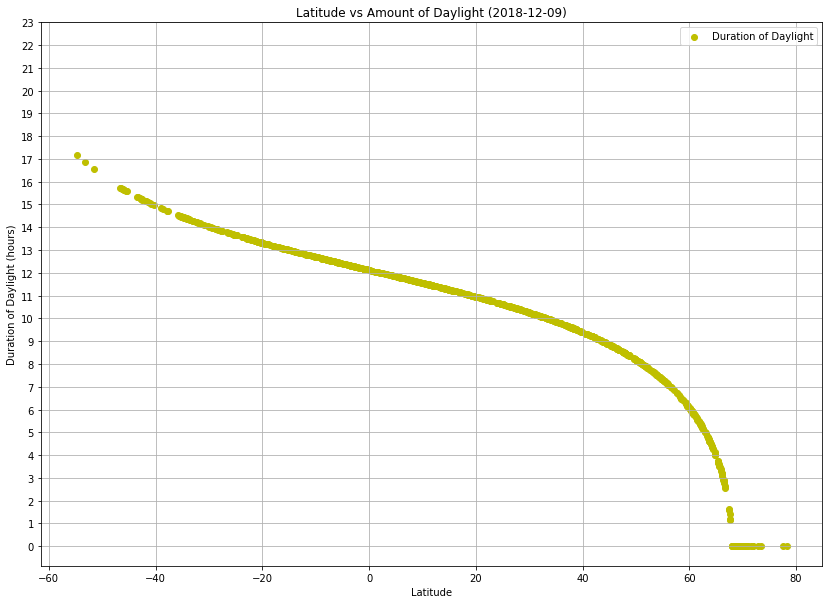

In [23]:
# Scatter plot of Latitude vs Duration of Daylight
x = city_weather_df["API Latitude"]
y = city_weather_df["Daylight Time"]

time_label = np.arange(0, 24)

plt.scatter(x, y, label="Duration of Daylight", color="y")

title = "Latitude vs Amount of Daylight (" + pullDate +")"
plt.title(title)
plt.xlabel("Latitude")
plt.ylabel("Duration of Daylight (hours)")
plt.legend(loc='best')

plt.yticks(np.arange(0, (24*60*60), (60*60)), time_label)

plt.grid()

plt.gcf().set_size_inches(14, 10)

# Save the Figure
plt.savefig("output/Bonus_LatitudeVsDurationOfDaylight.png")

# Show the Figure
plt.show()

#### Latitude vs Time of Sunrise / Sunset Plot

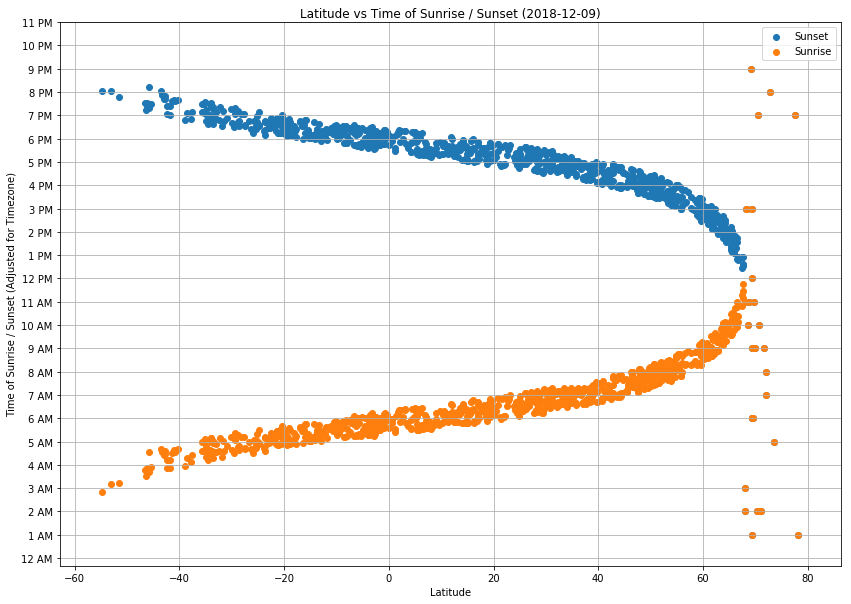

In [24]:
# Scatter plot of Latitude vs Time of Sunrise / Sunset

# Plot local Sunrise times
x1 = city_weather_df["API Latitude"]
y1 = city_weather_df["Adjusted Sunrise"]

# Plot local Sunset times
x2 = city_weather_df["API Latitude"]
y2 = city_weather_df["Adjusted Sunset"]

time_label = ["12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM",
              "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"]

plt.scatter(x2, y2, label="Sunset")
plt.scatter(x1, y1, label="Sunrise")

title = "Latitude vs Time of Sunrise / Sunset (" + pullDate +")"
plt.title(title)
plt.xlabel("Latitude")
plt.ylabel("Time of Sunrise / Sunset (Adjusted for Timezone)")
plt.legend(loc='best')

plt.yticks(np.arange(0, (24*60*60), (60*60)), time_label)

plt.grid()

plt.gcf().set_size_inches(14, 10)

# Save the Figure
plt.savefig("output/Bonus_LatitudeVsSunriseSunsetTime.png")

# Show the Figure
plt.show()

#### Geographic Coordinates of Cities Plot

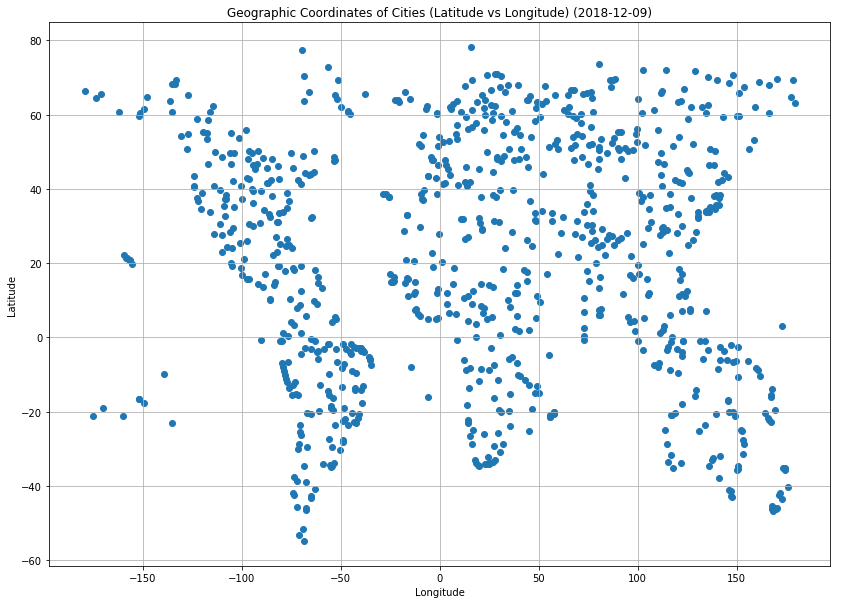

In [25]:
# Plot geographic coordinates of the cities
x = city_weather_df["API Longitude"]
y = city_weather_df["API Latitude"]

plt.scatter(x, y)

title = "Geographic Coordinates of Cities (Latitude vs Longitude) (" + pullDate +")"
plt.title(title)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.grid()

plt.gcf().set_size_inches(14, 10)

# Save the Figure
plt.savefig("output/Bonus_CityGeographicCoordinates.png")

# Show the Figure
plt.show()

You can distinctly see the edges of the continents.  This is due to the random coordinates that are actually on the oceans being asigned to the nearest cities which would happen to be on the nearest coastline.  Even though the geographic coordinates should be randomly distributed throughout the world, in actuality, 70% of the surface area of the earth is water, and thus a significant number of coordinates become concentrated on coastal cities.  This in turn makes a geographic coordinate plot more distinct in determining the edges of the various contitnents.